In [80]:
### mports ###
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, log, sqrt
from scipy.special import erf
from scipy.linalg import solve_banded
from scipy.stats import norm
from tqdm import tqdm


In [39]:
#### Black-Scholes ####
def bsexact(sigma: float, R: float, K: float, T: float, s: float):
    d1 = (log(s/K)+(R+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    F = 0.5*s*(1+erf(d1/sqrt(2)))-exp(-R*T)*K*0.5*(1+erf(d2/sqrt(2)))
    return F

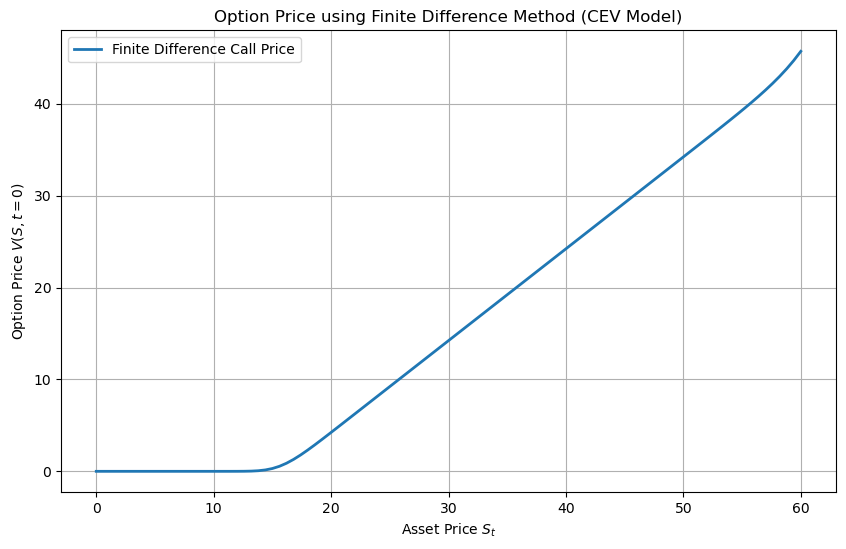

In [8]:
### FD Explicit Method ###

# Finite difference parameters
K = 15          # Strike price
S_max = 4 * K    # Maximum asset price
S_min = 0       # Minimum asset price
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility
gamma = 0.8     # Elasticity parameter (CEV model)
T = 0.5         # Time to maturity
t_0 = 0         # Initial time
N_s = 100       # Number of asset price grid points
N_t = 500       # Number of time steps

# Discretization of asset price and time
dS = (S_max - S_min) / N_s
dt = T / N_t

# Asset price grid
S = np.linspace(S_min, S_max, N_s+1)

# Time grid
t = np.linspace(t_0, T, N_t+1)

# Initialize the option price matrix
V = np.zeros((N_s+1, N_t+1))

# Payoff at maturity (t = T) for a European call option
V[:, -1] = np.maximum(S - K, 0)

# Boundary conditions
V[0, :] = 0  # V(S=0, t) = 0 for a call option
V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

# Vectorized Finite difference loop (explicit method)
for j in reversed(range(N_t)):  # Loop over time from T to 0
    delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  # First derivative (vectorized)
    gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2)  # Second derivative (vectorized)

    # CEV-based sigma term (S^gamma)
    diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
    drift_term = r * S[1:-1] * delta
    discount_term = r * V[1:-1, j+1]

    # Update option value using finite differences (vectorized)
    V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

# Extract the option prices at time t=0
option_price_finite_diff = V[:, 0]

# Plot the option price as a function of asset price
plt.figure(figsize=(10, 6))
plt.plot(S, option_price_finite_diff, label="Finite Difference Call Price", lw=2)
plt.xlabel('Asset Price $S_t$')
plt.ylabel('Option Price $V(S, t=0)$')
plt.title('Option Price using Finite Difference Method (CEV Model)')
plt.legend()
plt.grid(True)
plt.show()

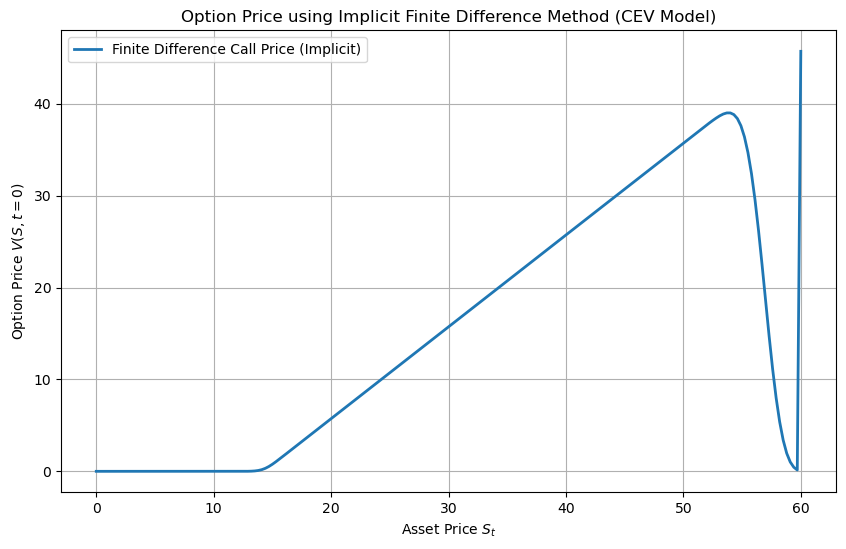

In [33]:
### FD Implicit Method ###

# Parameters
K = 15          # Strike price
S_max = 4 * K   # Maximum asset price
S_min = 0       # Minimum asset price
N_s = 200       # Number of asset price grid points #100
t_0 = 0     # Initial time
T = 0.5         # Time to maturity
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility
gamma = 0.5    # Elasticity parameter
# Time step counts
N_t = 500  


# Discretization of asset price and time
dS = (S_max - S_min) / N_s
dt = T / N_t

# Asset price grid
S = np.linspace(S_min, S_max, N_s+1)

# Time grid
t = np.linspace(t_0, T, N_t+1)

# Initialize the option price matrix
V = np.zeros((N_s+1, N_t+1))

# Payoff at maturity (t = T) for a European call option
V[:, -1] = np.maximum(S - K, 0)

# Boundary conditions
V[0, :] = 0  # V(S=0, t) = 0 for a call option
V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

# Construct the tridiagonal matrix coefficients
alpha = 0.5 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 - r * S[1:-1] / dS)
beta = -dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r)
gamma_term = 0.5 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r * S[1:-1] / dS)

# Coefficients for Crank-Nicolson scheme (0.5 for implicit and 0.5 for explicit terms)
#alpha = 0.25 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 - r * S[1:-1] / dS)
#beta = -0.5 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r)
#gamma_term = 0.25 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r * S[1:-1] / dS)

# Update the tridiagonal matrix construction as in the previous setup

# Prepare the diagonals for the banded solver (for tridiagonal matrix)
lower_diag = -alpha[1:]  # lower diagonal (sub-diagonal)
main_diag = 1 - beta     # main diagonal
upper_diag = -gamma_term[:-1]  # upper diagonal (super-diagonal)

# Implicit method: solve the system at each time step
for j in reversed(range(N_t)):  # Loop over time from T to 0
    # Construct the RHS (right-hand side) as the current values of V[:, j+1]
    rhs = V[1:-1, j+1]

    # Solve the linear system: A * V[:, j] = V[:, j+1]
    ab = np.zeros((3, len(main_diag)))
    ab[0, 1:] = upper_diag  # upper diagonal
    ab[1, :] = main_diag    # main diagonal
    ab[2, :-1] = lower_diag  # lower diagonal

    V[1:-1, j] = solve_banded((1, 1), ab, rhs)

# Extract the option prices at time t=0
option_price_finite_diff = V[:, 0]

# Plot the option price as a function of asset price
plt.figure(figsize=(10, 6))
plt.plot(S, option_price_finite_diff, label="Finite Difference Call Price (Implicit)", lw=2)
plt.xlabel('Asset Price $S_t$')
plt.ylabel('Option Price $V(S, t=0)$')
plt.title('Option Price using Implicit Finite Difference Method (CEV Model)')
plt.legend()
plt.grid(True)
plt.show()

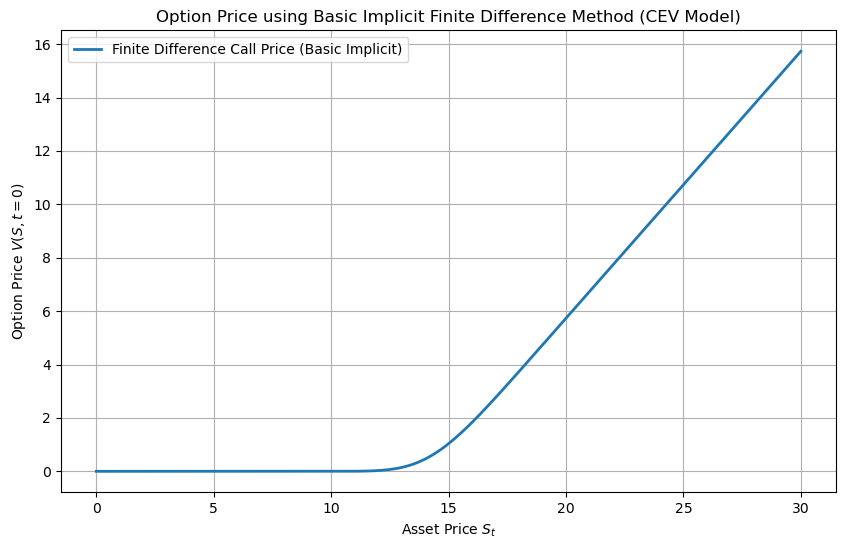

In [34]:
# Parameters
K = 15          # Strike price
S_max = 2 * K   # Maximum asset price
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility
gamma = 0.8     # Elasticity parameter
T = 0.5         # Time to maturity
N_s = 200       # Number of asset price grid points
N_t = 500       # Number of time steps

dS = S_max / N_s  
dt = T / N_t      

S = np.linspace(0, S_max, N_s + 1)
t = np.linspace(0, T, N_t + 1)

V = np.zeros((N_s + 1, N_t + 1))

V[:, -1] = np.maximum(S - K, 0)

V[0, :] = 0  
V[-1, :] = S_max - K * np.exp(-r * (T - t))  

for j in reversed(range(N_t)):  
    for i in range(1, N_s):
        delta_V = (V[i+1, j+1] - V[i-1, j+1]) / (2 * dS)
        gamma_V = (V[i+1, j+1] - 2 * V[i, j+1] + V[i-1, j+1]) / (dS**2)
        
        V[i, j] = V[i, j+1] + dt * (r * S[i] * delta_V + 0.5 * sigma**2 * S[i]**(2 * gamma) * gamma_V - r * V[i, j+1])

option_price_finite_diff = V[:, 0]

plt.figure(figsize=(10, 6))
plt.plot(S, option_price_finite_diff, label="Finite Difference Call Price Implicit", lw=2)
plt.xlabel('Asset Price $S_t$')
plt.ylabel('Option Price $V(S, t=0)$')
plt.title('Option Price using Implicit Finite Difference Method (CEV Model)')
plt.legend()
plt.grid(True)
plt.show()


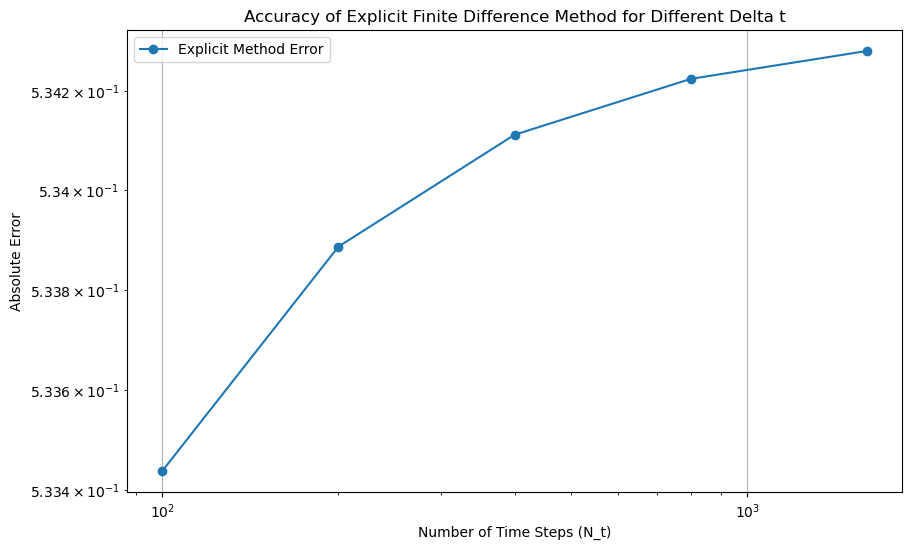

In [75]:
### Accuracy FD Explicit dt ###

# Function to compute option price using explicit finite difference method (for gamma = 1)
def finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t):
    # Discretization of asset price and time
    dS = S_max / N_s
    dt = T / N_t

    # Asset price grid
    S = np.linspace(0, S_max, N_s+1)

    # Time grid
    t = np.linspace(0, T, N_t+1)

    # Initialize the option price matrix
    V = np.zeros((N_s+1, N_t+1))

    # Payoff at maturity (t = T) for a European call option
    V[:, -1] = np.maximum(S - K, 0)

    # Boundary conditions
    V[0, :] = 0  # V(S=0, t) = 0 for a call option
    V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

    # Finite difference loop (explicit method)
    for j in reversed(range(N_t)):  # Loop over time from T to 0
        delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  # First derivative (vectorized)
        gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2)  # Second derivative (vectorized)

        # CEV-based sigma term (S^gamma)
        diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
        drift_term = r * S[1:-1] * delta
        discount_term = r * V[1:-1, j+1]

        # Update option value using finite differences (vectorized)
        V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

    return V[:, 0], S  # Return option prices at t=0 and asset prices

# Parameters
K = 15
S_max = 4 * K
r = 0.1
sigma = 0.25
gamma = 1  # Gamma = 1 for Black-Scholes
T = 0.5
S0 = 14

# Exact Black-Scholes price for gamma = 1
exact_price = bsexact(sigma, r, K, T, S0)

# Range of delta t values (different time steps)
Nt_values = [100, 200, 400, 800, 1600]  # Different grid sizes for time steps
N_s = 100  # Fixed number of asset price grid points

# Store the errors for each delta t
errors = []

# Loop over different values of N_t
for N_t in Nt_values:
    # Compute the finite difference option price
    fd_price, S_grid = finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t)
    
    # Find the option price closest to S0 in the finite difference grid
    idx = (np.abs(S_grid - S0)).argmin()  # Find index where S is closest to S0
    fd_price_at_S0 = fd_price[idx]
    
    # Compute the absolute error
    error = np.abs(fd_price_at_S0 - exact_price)
    errors.append((N_t, error))

# Convert errors to a NumPy array for easier manipulation
errors = np.array(errors)

# Plotting the errors
plt.figure(figsize=(10, 6))
plt.loglog(errors[:, 0], errors[:, 1], 'o-', label="Explicit Method Error")
plt.xlabel('Number of Time Steps (N_t)')
plt.ylabel('Absolute Error')
plt.title('Accuracy of Explicit Finite Difference Method for Different Delta t')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\2492170682.py:31: RuntimeWarning: overflow encountered in multiply
  diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\2492170682.py:27: RuntimeWarning: invalid value encountered in subtract
  delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  # First derivative (vectorized)
C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\2492170682.py:36: RuntimeWarning: invalid value encountered in subtract
  V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)
C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\2492170682.py:36: RuntimeWarning: invalid value encountered in add
  V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)


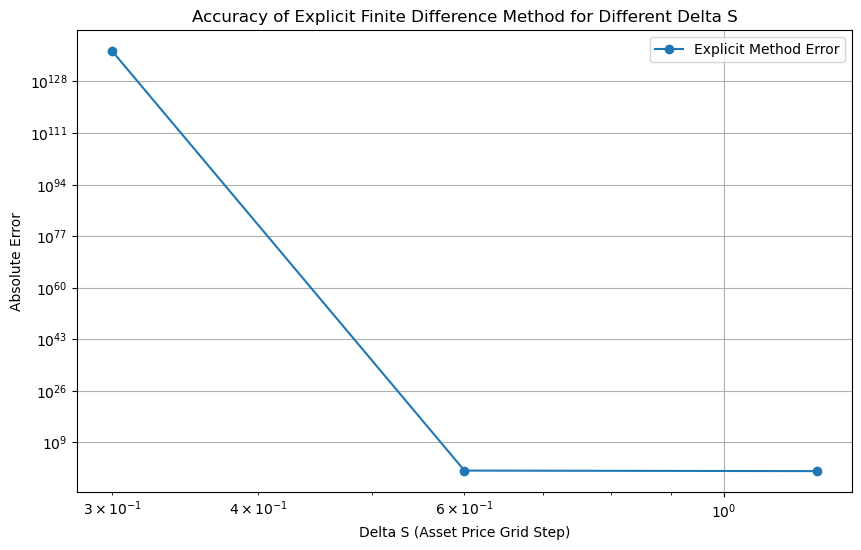

In [15]:
### Accuracy FD Explicit ds ###

# Function to compute option price using explicit finite difference method (for gamma = 1)
def finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t):
    # Discretization of asset price and time
    dS = S_max / N_s
    dt = T / N_t

    # Asset price grid
    S = np.linspace(0, S_max, N_s+1)

    # Time grid
    t = np.linspace(0, T, N_t+1)

    # Initialize the option price matrix
    V = np.zeros((N_s+1, N_t+1))

    # Payoff at maturity (t = T) for a European call option
    V[:, -1] = np.maximum(S - K, 0)

    # Boundary conditions
    V[0, :] = 0  # V(S=0, t) = 0 for a call option
    V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

    # Finite difference loop (explicit method)
    for j in reversed(range(N_t)):  # Loop over time from T to 0
        delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  # First derivative (vectorized)
        gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2)  # Second derivative (vectorized)

        # CEV-based sigma term (S^gamma)
        diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
        drift_term = r * S[1:-1] * delta
        discount_term = r * V[1:-1, j+1]

        # Update option value using finite differences (vectorized)
        V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

    return V[:, 0], S  # Return option prices at t=0 and asset prices

# Parameters
K = 15
S_max = 4 * K
r = 0.1
sigma = 0.25
gamma = 1  # Gamma = 1 for Black-Scholes
T = 0.5
S0 = 14
N_t = 500  # Fixed number of time steps

# Exact Black-Scholes price for gamma = 1
exact_price = bsexact(sigma, r, K, T, S0)

# Range of delta S values (different asset price grids)
Ns_values = [50, 100, 200, 400]  # Different grid sizes for asset price

# Store the errors for each delta S
errors = []

# Loop over different values of N_s
for N_s in Ns_values:
    # Compute the finite difference option price
    fd_price, S_grid = finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t)
    
    # Find the option price closest to S0 in the finite difference grid
    idx = (np.abs(S_grid - S0)).argmin()  # Find index where S is closest to S0
    fd_price_at_S0 = fd_price[idx]
    
    # Compute the absolute error
    error = np.abs(fd_price_at_S0 - exact_price)
    errors.append((S_max / N_s, error))  # Store delta S and the corresponding error

# Convert errors to a NumPy array for easier manipulation
errors = np.array(errors)

# Plotting the errors
plt.figure(figsize=(10, 6))
plt.loglog(errors[:, 0], errors[:, 1], 'o-', label="Explicit Method Error")
plt.xlabel('Delta S (Asset Price Grid Step)')
plt.ylabel('Absolute Error')
plt.title('Accuracy of Explicit Finite Difference Method for Different Delta S')
plt.grid(True)
plt.legend()
plt.show()

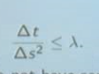

## Stability

The plot shows the relative error of the explicit finite difference method for various space steps and time steps Stability is achieved above the red curve, where the method yields small relative errors, while below the curve, instability leads to larger errors. The red curve represents the stability condition, illustrating the quadratic relationship between time and space steps required for stability.

For N_t = 300, λ = 0.010416666666666666


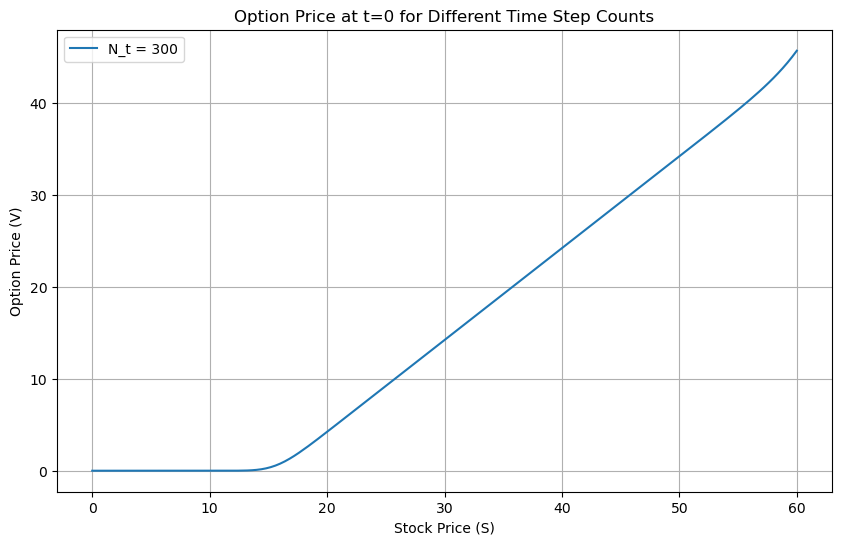

In [95]:
### Stability ###

def finite_difference_explicit(K: int, S_max: int, S_min: int, N_s: int, t_start: int, T: int, N_t: int, r: float, sigma: float, gamma: float):
    dS = (S_max - S_min) / N_s
    dt = (T - t_start) / N_t

    lambda_val = dt / dS**2
    print(f'For N_t = {N_t}, λ = {lambda_val}')

    S = np.linspace(S_min, S_max, N_s+1)

    t = np.linspace(t_start, T, N_t+1)

    V = np.zeros((N_s+1, N_t+1))

    V[:, -1] = np.maximum(S - K, 0)

    V[0, :] = 0 
    V[-1, :] = S_max - K * np.exp(-r * (T - t)) 

    for j in reversed(range(N_t)): 
        delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  
        gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2)  

        diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
        drift_term = r * S[1:-1] * delta
        discount_term = r * V[1:-1, j+1]

        V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

    return V[:, 0], S  # Return option prices at t=0 and asset prices

# Parameters
K = 15          # Strike price
S_max = 4 * K   # Maximum asset price
S_min = 0       # Minimum asset price
N_s = 150       # Number of asset price grid points #100
t_start = 0     # Initial time
T = 0.5         # Time to maturity
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility
gamma = 0.8     # Elasticity parameter
N_t_list = [300] # Time step counts  

plt.figure(figsize=(10, 6))  

for N_t in N_t_list:
    V_0, S = finite_difference_explicit(K, S_max, S_min, N_s, t_start, T, N_t, r, sigma, gamma)
    plt.plot(S, V_0, label=f'N_t = {N_t}', linewidth=1.5)  

plt.title('Option Price at t=0 for Different Time Step Counts')
plt.xlabel('Stock Price (S)')
plt.ylabel('Option Price (V)')
plt.legend()
plt.grid(True)
plt.show()


Testing N values:  23%|██▎       | 23/100 [00:06<00:37,  2.03it/s]C:\Users\pontu\AppData\Local\Temp\ipykernel_22180\3328831341.py:20: RuntimeWarning: overflow encountered in multiply
  diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
C:\Users\pontu\AppData\Local\Temp\ipykernel_22180\3328831341.py:17: RuntimeWarning: invalid value encountered in subtract
  delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)
C:\Users\pontu\AppData\Local\Temp\ipykernel_22180\3328831341.py:24: RuntimeWarning: invalid value encountered in subtract
  V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)
C:\Users\pontu\AppData\Local\Temp\ipykernel_22180\3328831341.py:24: RuntimeWarning: invalid value encountered in add
  V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)
Testing N values:  42%|████▏     | 42/100 [00:21<00:52,  1.11it/s]C:\Users\pontu\AppData\Local\Temp\ipykernel_22180\3328831341.py:24: RuntimeWarning: overflow encountered in su

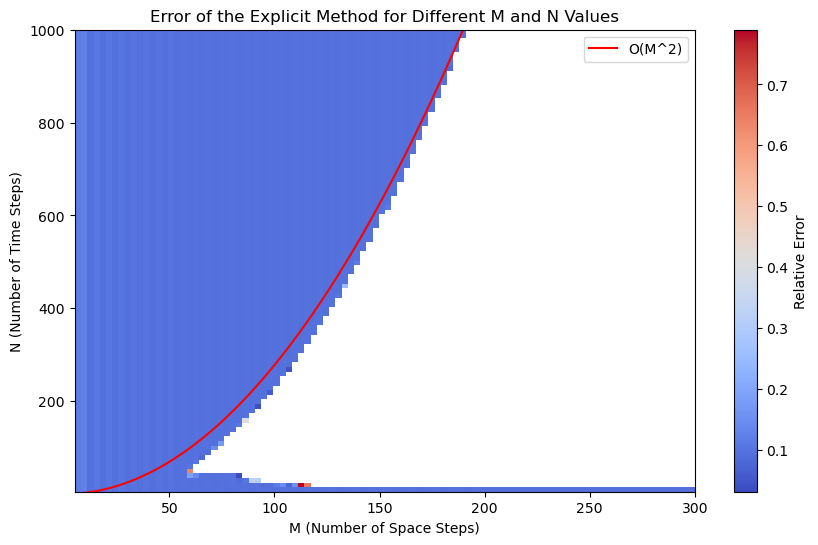

In [107]:
def finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t):
    dS = S_max / N_s
    dt = T / N_t

    S = np.linspace(0, S_max, N_s+1)

    t = np.linspace(0, T, N_t+1)

    V = np.zeros((N_s+1, N_t+1))

    V[:, -1] = np.maximum(S - K, 0)

    V[0, :] = 0 
    V[-1, :] = S_max - K * np.exp(-r * (T - t))  

    for j in reversed(range(N_t)):  
        delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  
        gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2) 

        diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
        drift_term = r * S[1:-1] * delta
        discount_term = r * V[1:-1, j+1]

        V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

    return V[:, 0], S 

# Parameters
K = 15          # Strike price
S_max = 4 * K   # Maximum asset price
T = 0.5         # Time to maturity
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility
gamma = 1       # Elasticity parameter
N_t_values = np.linspace(5, 1000, 100, dtype=int)
N_s_values = np.linspace(5, 300, 100, dtype=int)

error_matrix = np.full((len(N_t_values), len(N_s_values)), np.nan)

for i, N_t in tqdm(enumerate(N_t_values), total=len(N_t_values)):
    for j, N_s in enumerate(N_s_values):
        try:
            V, S_grid = finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t)
            if np.isfinite(V).all():
                index = N_s // 2  
                S = S_grid[index]
                exact_value = bsexact(sigma, r, K, T, S) 
                estimated_value = V[index]  
                relative_error = np.abs(exact_value - estimated_value) / exact_value

                if relative_error < 1: 
                    error_matrix[i, j] = relative_error
                else:
                    error_matrix[i, j] = np.nan
        except Exception as e:
            error_matrix[i, j] = np.nan

lamda = 0.005 #Found by testing by hand
plt.figure(figsize=(10, 6))
plt.plot(N_s_values, (T * N_s_values**2) / (S_max**2 * lamda), label='O(M^2)', color='red')
plt.imshow(error_matrix, cmap='coolwarm', origin='lower', extent=[N_s_values[0], N_s_values[-1], N_t_values[0], N_t_values[-1]], aspect='auto')
plt.colorbar(label='Relative Error')
plt.xlabel('M (Number of Space Steps)')
plt.ylabel('N (Number of Time Steps)')
plt.title('Error of the Explicit Method for Different M and N Values')
plt.legend()
plt.show()


## Gamma

The plot shows the option prices for different values of the elasticity parameter γ in the CEV model, ranging from 0.1 to 1.0. As the asset price increases, the option prices behave similarly for all values of γ. The slight differences between the curves reflect the influence of the varying volatility structure imposed by different γ values, but the overall impact of γ is minimal in this range. Interestingly, small signs of instability appear for the lower γ values, which is influenced by the predefined N and M values in the code. Adjusting these parameters will shift which end of the γ-spectrum exhibits instability trends, if any.

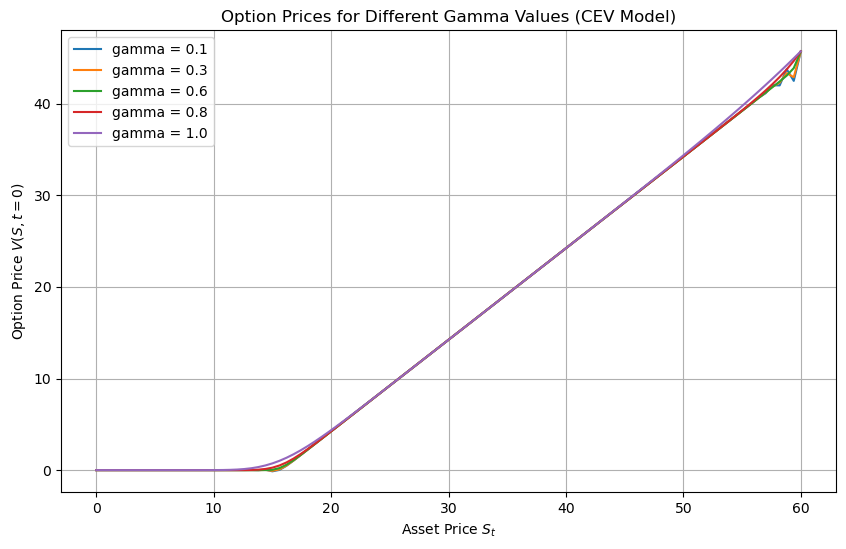

In [106]:
def finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t):
    dS = S_max / N_s
    dt = T / N_t

    S = np.linspace(0, S_max, N_s+1)

    t = np.linspace(0, T, N_t+1)

    V = np.zeros((N_s+1, N_t+1))

    V[:, -1] = np.maximum(S - K, 0)

    V[0, :] = 0 
    V[-1, :] = S_max - K * np.exp(-r * (T - t))  

    for j in reversed(range(N_t)):  
        delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  
        gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2) 

        diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
        drift_term = r * S[1:-1] * delta
        discount_term = r * V[1:-1, j+1]

        V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

    return V[:, 0], S 

# Parameters
K = 15          # Strike price
S_max = 4 * K   # Maximum asset price
T = 0.5         # Time to maturity
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility
N_s = 100       # Number of asset price grid points
N_t = 300       # Number of time steps
gamma_values = np.linspace(0.1, 1, 5)

plt.figure(figsize=(10, 6))
for gamma in gamma_values:
    V, S = finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t)
    plt.plot(S, V, label=f'gamma = {gamma:.1f}')

plt.xlabel('Asset Price $S_t$')
plt.ylabel('Option Price $V(S, t=0)$')
plt.title('Option Prices for Different Gamma Values (CEV Model)')
plt.legend()
plt.grid(True)
plt.show()

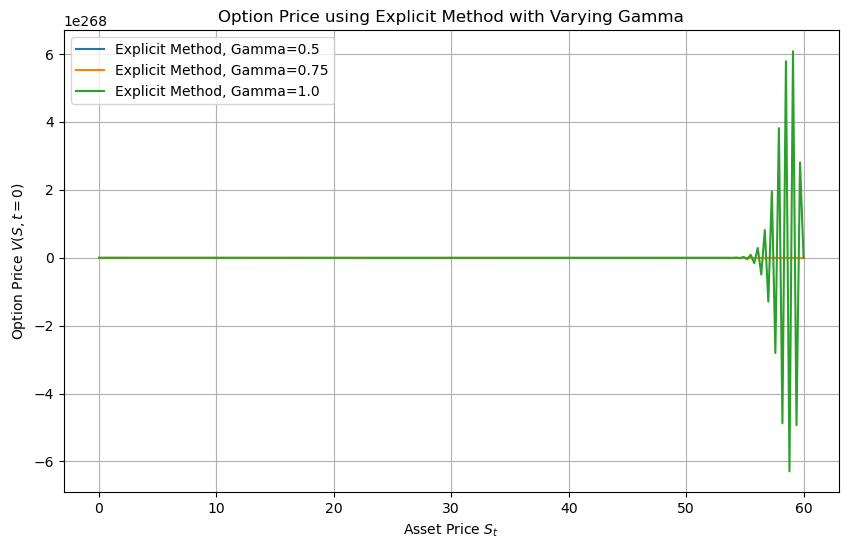

In [99]:
# Function for finite difference method using explicit scheme
def finite_difference_explicit(K: int, S_max: int, S_min: int, N_s: int, t_start: int, T: int, N_t: int, r: float, sigma: float, gamma: float):
    # Discretization of asset price and time
    dS = (S_max - S_min) / N_s
    dt = (T - t_start) / N_t
    
    # Asset price grid
    S = np.linspace(S_min, S_max, N_s+1)

    # Time grid
    t = np.linspace(t_start, T, N_t+1)

    # Initialize the option price matrix
    V = np.zeros((N_s+1, N_t+1))

    # Payoff at maturity (t = T) for a European call option
    V[:, -1] = np.maximum(S - K, 0)

    # Boundary conditions
    V[0, :] = 0  # V(S=0, t) = 0 for a call option
    V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

    # Finite difference loop (explicit method)
    for j in reversed(range(N_t)):  # Loop over time from T to 0
        delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  # First derivative (vectorized)
        gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2)  # Second derivative (vectorized)

        # CEV-based sigma term (S^gamma)
        diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
        drift_term = r * S[1:-1] * delta
        discount_term = r * V[1:-1, j+1]

        # Update option value using finite differences (vectorized)
        V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

    return V[:, 0], S  # Return option prices at t=0 and asset prices


# Parameters
K = 15          # Strike price
S_max = 4 * K   # Maximum asset price
S_min = 0       # Minimum asset price
N_s = 200       # Number of asset price grid points #100
t_start = 0     # Initial time
T = 0.5         # Time to maturity
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility

# Time step counts to test
N_t = 400  # Testing with different time steps #55


# Varying gamma
gamma_values = [0.5, 0.75, 1.0]

# Plot results for explicit method
plt.figure(figsize=(10, 6))
for gamma in gamma_values:
    option_price, S = finite_difference_explicit(K, S_max, S_min, N_s, t_start, T, N_t, r, sigma, gamma)
    plt.plot(S, option_price, label=f'Explicit Method, Gamma={gamma}')

plt.xlabel('Asset Price $S_t$')
plt.ylabel('Option Price $V(S, t=0)$')
plt.title('Option Price using Explicit Method with Varying Gamma')
plt.legend()
plt.grid(True)
plt.show()
